# Build your own CNN on CIFAR10 image data

In this demo, you will learn to:

* load cifer10 dataset.
* preprocess the data
* build CNN to train and test on cifar10 data
* see the effect of dropout and batch normalization
* perform data augmentation

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) is a collection of 60,000 color, 32x32-pixel images in ten classes. Classes include common objects such as airplanes, automobiles, birds, cats and so on. There are 50,000 train and 10,000 test images. Pytorch can automatically download the dataset from `torchvision.datasets`. Note that it will take some time to downloading the dataset for the first time. But, the download will be saved in cache and would not be needed to download again. 

State of the art results are achieved using very large Convolutional Neural networks. Model performance is reported in [classification accuracy](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130), with state-of-the-art results at 96.5% with human performance on the problem at 94%.

A CIFAR-10, Pytorch tutorial can be found at [Pytorch CIFAR-10 Tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).


## Start with loading basic packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn

Create a 3×3 plot of photographs. The images have been scaled up from their small 32×32 size, but you can clearly see trucks horses and cars. You can also see some distortion in some images that have been forced to the square aspect ratio.

In [2]:
# Create CIFAR-10 dataset object
train_ds = CIFAR10('data/cifar-10', train=True, download=True, transform=transforms.ToTensor())


batch_size = 10
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [3]:
def imshow(img,title=None):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    if title:
        plt.title(title)

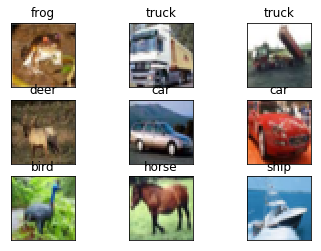

In [4]:
# Get batch
data = next(iter(train_dl))
# split into images and labels
images, labels = data
# create a grid of 3x3 images
for i in range(9):
    plt.subplot(330 + 1 + i)
    imshow(images[i],classes[labels[i]])

plt.show()

## Preprocess the data 
In this case we want to convert the image to a pytorch tensor, using `transforms.ToTensor`, and then normalize the data to be between -1 and 1 with `transforms.Normalize`. We can compose these two transformations together using `transforms.Compose`. For information on image transformations see [Torchvision Transforms Docs](https://pytorch.org/docs/stable/torchvision/transforms.html).

In [5]:
# Create transform that performs normalization
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Create datasets
train_ds = CIFAR10('data/cifar-10', train=True, download=True, transform=transform)
test_ds = CIFAR10('data/cifar-10', train=False, download=True, transform=transform)

# Create Dataloaders
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


## Building a Simple CNN model

Let’s start off by defining a simple CNN structure as a baseline and evaluate how well it performs on the problem.

We will use a structure with two convolutional layers each followed by max pooling and a flattening out of the network to fully connected layers to make predictions.

Start with defining the important parameters

In [6]:
epochs = 20
lrate = 0.05
decay = lrate/epochs

### Build the basic CNN model

Our baseline network structure can be summarized as follows:

* First convolutional layer that converts the input image to 32 feature maps with a kernel size of 3×3, and a rectifier (ReLU) activation function, followed by Max Pooling.
* Second convolutional layer 
* Flatten layer.
* Fully connected layer with 512 units and a rectifier activation function.
* Fully connected output layer with 10 units and a softmax activation function.

In [7]:
num_classes = len(classes)

class BasicNet(nn.Module):
    def __init__(self):
        super(BasicNet, self).__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3,16,3,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16,16,3,padding=1)
        self.fc1 = nn.Linear(16*8**2, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self,x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0),-1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = BasicNet()

### Choose the optimizer and compile the model
We use a `nn.CrossEntropyLoss` and optimize it using `Adam` optimizer.

We also want to schedule the learning rate so we have defined a `lr_scheduler` object.
We have choosen the `LambdaLR` scheduler, which changes the learning rate as an arbitrary function of the epoch number.

Later on we will call `scheduler.step()` at the beginning of every epoch to make the change in learning rate.

In [8]:
import torch.optim as optim

# initiate Adam optimizer
opt = optim.Adam(model.parameters(), lr=lrate)

# Create learning rate scheduler
lambda1 = lambda epoch: lrate - decay*epoch
scheduler = optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda1)

# initiate loss function
criterion = nn.CrossEntropyLoss()

print(str(model))

BasicNet(
  (relu): ReLU()
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


### Fit the model on training data
We can fit this model with 20 epochs and a batch size of 32.

A small number of epochs was chosen to help keep this demo moving. Normally the number of epochs would be much larger (say 10,000) for this problem.

Once the model is fit, we evaluate it on the test dataset and print out the classification accuracy.

In [9]:
basic_tr_accuracy = []
basic_ts_accuracy = []

for epoch in range(epochs):
    # Take scheduler step
    scheduler.step()
    
    correct = 0 # initialize error counter
    total = 0 # initialize total counter
    model.train() # put model in training mode
    # iterate over training set
    for train_iter, data in enumerate(train_dl):
        x_batch,y_batch = data
        out = model(x_batch)
        # Compute Loss
        loss = criterion(out,y_batch)
        # Zero gradients
        opt.zero_grad()
        # Compute gradients using back propagation
        loss.backward()
        # Take an optimization 'step'
        opt.step()
        
        # Compute Accuracy
        _, predicted = torch.max(out.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
        

    basic_tr_accuracy.append( 100*correct/total )
    
    correct = 0
    total = 0
    model.eval() # put model in evaluation mode
    with torch.no_grad():
        for data in test_dl:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    basic_ts_accuracy.append( 100*correct/total )
    
    # Print details every print_mod epoch
    print('Epoch: {0:2d}   Train Accuracy: {1:.3f}%   Test Accuracy: {2:.3f}%'.format(epoch+1, basic_tr_accuracy[epoch], basic_ts_accuracy[epoch]))
        

print('Done!')

# Save
PATH = 'saved_basic_model.pt'
torch.save(model.state_dict(), PATH)

Epoch:  1   Train Accuracy: 51.612%   Test Accuracy: 61.280%
Epoch:  2   Train Accuracy: 64.428%   Test Accuracy: 65.050%
Epoch:  3   Train Accuracy: 70.260%   Test Accuracy: 67.000%
Epoch:  4   Train Accuracy: 75.464%   Test Accuracy: 68.000%
Epoch:  5   Train Accuracy: 79.868%   Test Accuracy: 67.250%
Epoch:  6   Train Accuracy: 84.356%   Test Accuracy: 67.980%
Epoch:  7   Train Accuracy: 88.146%   Test Accuracy: 68.220%
Epoch:  8   Train Accuracy: 91.472%   Test Accuracy: 67.510%
Epoch:  9   Train Accuracy: 94.042%   Test Accuracy: 67.640%
Epoch: 10   Train Accuracy: 95.978%   Test Accuracy: 67.890%
Epoch: 11   Train Accuracy: 97.112%   Test Accuracy: 67.230%
Epoch: 12   Train Accuracy: 98.082%   Test Accuracy: 68.090%
Epoch: 13   Train Accuracy: 98.658%   Test Accuracy: 67.400%
Epoch: 14   Train Accuracy: 99.260%   Test Accuracy: 68.030%
Epoch: 15   Train Accuracy: 99.572%   Test Accuracy: 67.790%
Epoch: 16   Train Accuracy: 99.774%   Test Accuracy: 66.980%
Epoch: 17   Train Accura

Save and load the model

In [10]:
# Load
PATH = 'saved_basic_model.pt'
model = BasicNet()
model.load_state_dict(torch.load(PATH));
model.eval()

BasicNet(
  (relu): ReLU()
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

## Build model with batch normalization

Batch normalization speeds-up the learning. The `BatchNormalization` in pytorch applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. We add a batch normalization layer before each new layer. 

The model architecture can be summarized as

* Convolutional input layer, 32 feature maps with a size of 3×3, and a rectifier (ReLU) activation function.
* Batch normalization to normalize the input for the next layer
* Convolutional layer, 32 feature maps with a size of 3×3, and a rectifier activation function. 
* Max Pool layer with size 2×2.
* Flatten layer.
* Batch normalization to normalize the input for the next layer
* Fully connected layer with 512 units and a rectifier activation function.
* Batch normalization to normalize the input for the next layer
* Fully connected output layer with 10 units and a softmax activation function.


In [11]:
class BNNet(nn.Module):
    def __init__(self):
        super(BNNet, self).__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3,16,3,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,16,3,padding=1)
        self.bn2 = nn.BatchNorm1d(16*8**2)
        self.fc1 = nn.Linear(16*8**2, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self,x):
        x = self.bn1(self.pool(self.relu(self.conv1(x))))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.bn2(x.view(x.size(0),-1))
        x = self.bn3(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


model = BNNet()


# initiate Adam optimizer
opt = optim.Adam(model.parameters(), lr=lrate)

# Create learning rate scheduler
lambda1 = lambda epoch: lrate - decay*epoch
scheduler = optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda1)

# initiate loss function
criterion = nn.CrossEntropyLoss()

print(str(model))

BNNet(
  (relu): ReLU()
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


### Fit and evaluate the model with batch normalization
We will see that the training performs significantly better with batch normalization.

In [12]:
print('Using batch normalization but no dropout or data augmentation.')
# Fit the model


bn_tr_accuracy = []
bn_ts_accuracy = []

for epoch in range(epochs):
    # Take scheduler step
    scheduler.step()
    
    correct = 0 # initialize error counter
    total = 0 # initialize total counter
    model.train() # put model in training mode
    # iterate over training set
    for train_iter, data in enumerate(train_dl):
        x_batch,y_batch = data
        out = model(x_batch)
        # Compute Loss
        loss = criterion(out,y_batch)
        # Zero gradients
        opt.zero_grad()
        # Compute gradients using back propagation
        loss.backward()
        # Take an optimization 'step'
        opt.step()
        
        # Compute Accuracy
        _, predicted = torch.max(out.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
        

    bn_tr_accuracy.append( 100*correct/total )
    
    correct = 0
    total = 0
    model.eval() # put model in evaluation mode
    with torch.no_grad():
        for data in test_dl:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    bn_ts_accuracy.append( 100*correct/total )
    
    # Print details every print_mod epoch
    print('Epoch: {0:2d}   Train Accuracy: {1:.3f}%   Test Accuracy: {2:.3f}%'.format(epoch+1, bn_tr_accuracy[epoch], bn_ts_accuracy[epoch]))
        

print('Done!')

# Save
PATH = 'saved_bn_model.pt'
torch.save(model.state_dict(), PATH)

Using batch normalization but no dropout or data augmentation.
Epoch:  1   Train Accuracy: 55.898%   Test Accuracy: 65.170%
Epoch:  2   Train Accuracy: 67.136%   Test Accuracy: 69.130%
Epoch:  3   Train Accuracy: 72.418%   Test Accuracy: 70.200%
Epoch:  4   Train Accuracy: 75.460%   Test Accuracy: 71.470%
Epoch:  5   Train Accuracy: 78.832%   Test Accuracy: 71.550%
Epoch:  6   Train Accuracy: 81.524%   Test Accuracy: 72.000%
Epoch:  7   Train Accuracy: 83.938%   Test Accuracy: 71.920%
Epoch:  8   Train Accuracy: 86.828%   Test Accuracy: 72.450%
Epoch:  9   Train Accuracy: 89.010%   Test Accuracy: 72.160%
Epoch: 10   Train Accuracy: 90.460%   Test Accuracy: 71.590%
Epoch: 11   Train Accuracy: 92.142%   Test Accuracy: 72.070%
Epoch: 12   Train Accuracy: 93.298%   Test Accuracy: 72.520%
Epoch: 13   Train Accuracy: 94.288%   Test Accuracy: 72.320%
Epoch: 14   Train Accuracy: 95.056%   Test Accuracy: 72.290%
Epoch: 15   Train Accuracy: 95.806%   Test Accuracy: 72.970%
Epoch: 16   Train Accu

In [13]:
# Load
PATH = 'saved_bn_model.pt'
model = BNNet()
model.load_state_dict(torch.load(PATH));
model.eval();

## Dropout and Batch normalization

Dropout is a way to avoid overfitting. It forces the network to train only a random subset of nodes at each training index.

Here we copy the model with batch normalization, except we add dropout (before the fully connected layers) after batch normalization, to indicate that the next layer will be trained with dropout.  

In [14]:
# network with dropout and BN
class DropoutNet(nn.Module):
    def __init__(self):
        super(DropoutNet, self).__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3,16,3,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.bn1 = nn.BatchNorm2d(16)
        self.dropout1 = nn.Dropout2d(p=0.25)
        self.conv2 = nn.Conv2d(16,16,3,padding=1)
        self.bn2 = nn.BatchNorm1d(16*8**2)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(16*8**2, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self,x):
        #x = self.dropout1(self.bn1(self.pool(self.relu(self.conv1(x)))))
        x = self.bn1(self.pool(self.relu(self.conv1(x))))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.dropout2(self.bn2(x.view(x.size(0),-1)))
        x = self.dropout3(self.bn3(self.relu(self.fc1(x))))
        x = self.fc2(x)
        return x

model = DropoutNet()


# initiate Adam optimizer
opt = optim.Adam(model.parameters(), lr=lrate)

# Create learning rate scheduler
lambda1 = lambda epoch: lrate - decay*epoch
scheduler = optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda1)

# initiate loss function
criterion = nn.CrossEntropyLoss()

print(str(model))



DropoutNet(
  (relu): ReLU()
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.25)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


### Fit and evaluate the model with dropout

Note that with dropout you should increase the number of epochs to obtain similar results as without dropout. It is possible with more epochs we can further improve the validation accuracy.


In [15]:
print('Using batch normalization and dropout but no data augmentation.')
# Fit the model

drop_tr_accuracy = []
drop_ts_accuracy = []

for epoch in range(epochs):
    # Take scheduler step
    scheduler.step()
    
    correct = 0 # initialize error counter
    total = 0 # initialize total counter
    model.train() # put model in training mode
    # iterate over training set
    for train_iter, data in enumerate(train_dl):
        x_batch,y_batch = data
        out = model(x_batch)
        # Compute Loss
        loss = criterion(out,y_batch)
        # Zero gradients
        opt.zero_grad()
        # Compute gradients using back propagation
        loss.backward()
        # Take an optimization 'step'
        opt.step()
        
        # Compute Accuracy
        _, predicted = torch.max(out.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
        

    drop_tr_accuracy.append( 100*correct/total )
    
    correct = 0
    total = 0
    model.eval() # put model in evaluation mode
    with torch.no_grad():
        for data in test_dl:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    drop_ts_accuracy.append( 100*correct/total )
    
    # Print details every print_mod epoch
    print('Epoch: {0:2d}   Train Accuracy: {1:.3f}%   Test Accuracy: {2:.3f}%'.format(epoch+1, drop_tr_accuracy[epoch], drop_ts_accuracy[epoch]))
        

print('Done!')

# Save
PATH = 'saved_drop_model.pt'
torch.save(model.state_dict(), PATH)

# Load
model = DropoutNet()
model.load_state_dict(torch.load(PATH));
model.eval();

Using batch normalization and dropout but no data augmentation.
Epoch:  1   Train Accuracy: 48.422%   Test Accuracy: 61.000%
Epoch:  2   Train Accuracy: 57.218%   Test Accuracy: 64.440%
Epoch:  3   Train Accuracy: 60.470%   Test Accuracy: 66.770%
Epoch:  4   Train Accuracy: 62.538%   Test Accuracy: 68.400%
Epoch:  5   Train Accuracy: 63.812%   Test Accuracy: 70.370%
Epoch:  6   Train Accuracy: 65.148%   Test Accuracy: 71.320%
Epoch:  7   Train Accuracy: 65.986%   Test Accuracy: 72.170%
Epoch:  8   Train Accuracy: 67.064%   Test Accuracy: 73.470%
Epoch:  9   Train Accuracy: 67.778%   Test Accuracy: 73.060%
Epoch: 10   Train Accuracy: 68.576%   Test Accuracy: 74.010%
Epoch: 11   Train Accuracy: 69.074%   Test Accuracy: 74.580%
Epoch: 12   Train Accuracy: 69.526%   Test Accuracy: 74.670%
Epoch: 13   Train Accuracy: 70.134%   Test Accuracy: 75.230%
Epoch: 14   Train Accuracy: 70.568%   Test Accuracy: 76.140%
Epoch: 15   Train Accuracy: 71.182%   Test Accuracy: 75.680%
Epoch: 16   Train Acc

## Data Augmentation

Data augmentation is used to build a powerful image classifier using only very few training examples.
A tutorial for [building image classification models using very little data](
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) is helpful.


### First Build the model
We use the same model as we developed earlier.

In [16]:
model = DropoutNet()

# initiate Adam optimizer
opt = optim.Adam(model.parameters(), lr=lrate)

# Create learning rate scheduler
lambda1 = lambda epoch: lrate - decay*epoch
scheduler = optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda1)

# initiate loss function
criterion = nn.CrossEntropyLoss()

print(str(model))

DropoutNet(
  (relu): ReLU()
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.25)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


### Using real-time data augmentation

In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

For our training set we will use a different transformation that will include random translations and a horizontal flip with probablility 0.5. Note that these transformations are performed while the images are in the PIL format before they are converted to a tensor. Again, for more information on transformations, see [Torchvision Transforms Docs](https://pytorch.org/docs/stable/torchvision/transforms.html).



In [17]:
train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=0,translate=(0.1,0.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create new dataset with training transformation
train_ds = CIFAR10('data/cifar-10', train=True, download=True, transform=train_transform)

# Create Dataloaders
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)


Files already downloaded and verified


In [18]:
print('Using real-time data augmentation.')
# Fit the model
aug_tr_accuracy = []
aug_ts_accuracy = []

for epoch in range(epochs):
    # Take scheduler step
    scheduler.step()
    
    correct = 0 # initialize error counter
    total = 0 # initialize total counter
    model.train() # put model in training mode
    # iterate over training set
    for train_iter, data in enumerate(train_dl):
        x_batch,y_batch = data
        out = model(x_batch)
        # Compute Loss
        loss = criterion(out,y_batch)
        # Zero gradients
        opt.zero_grad()
        # Compute gradients using back propagation
        loss.backward()
        # Take an optimization 'step'
        opt.step()
        
        # Compute Accuracy
        _, predicted = torch.max(out.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
        

    aug_tr_accuracy.append( 100*correct/total )
    
    correct = 0
    total = 0
    model.eval() # put model in evaluation mode
    with torch.no_grad():
        for data in test_dl:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    aug_ts_accuracy.append( 100*correct/total )
    
    # Print details every print_mod epoch
    print('Epoch: {0:2d}   Train Accuracy: {1:.3f}%   Test Accuracy: {2:.3f}%'.format(epoch+1, aug_tr_accuracy[epoch], aug_ts_accuracy[epoch]))
        

print('Done!')

# Save
PATH = 'saved_aug_model.pt'
torch.save(model.state_dict(), PATH)

Using real-time data augmentation.
Epoch:  1   Train Accuracy: 43.514%   Test Accuracy: 56.300%
Epoch:  2   Train Accuracy: 51.818%   Test Accuracy: 63.480%
Epoch:  3   Train Accuracy: 54.586%   Test Accuracy: 63.640%
Epoch:  4   Train Accuracy: 56.618%   Test Accuracy: 66.370%
Epoch:  5   Train Accuracy: 58.084%   Test Accuracy: 67.220%
Epoch:  6   Train Accuracy: 58.928%   Test Accuracy: 68.580%
Epoch:  7   Train Accuracy: 59.586%   Test Accuracy: 69.630%
Epoch:  8   Train Accuracy: 60.226%   Test Accuracy: 70.360%
Epoch:  9   Train Accuracy: 60.974%   Test Accuracy: 70.060%
Epoch: 10   Train Accuracy: 61.916%   Test Accuracy: 70.830%
Epoch: 11   Train Accuracy: 62.248%   Test Accuracy: 70.950%
Epoch: 12   Train Accuracy: 62.906%   Test Accuracy: 72.550%
Epoch: 13   Train Accuracy: 63.560%   Test Accuracy: 72.890%
Epoch: 14   Train Accuracy: 63.930%   Test Accuracy: 73.070%
Epoch: 15   Train Accuracy: 64.300%   Test Accuracy: 73.650%
Epoch: 16   Train Accuracy: 64.636%   Test Accurac

In [19]:
# Load
PATH = 'saved_aug_model.pt'
model = DropoutNet()
model.load_state_dict(torch.load(PATH));
model.eval()

DropoutNet(
  (relu): ReLU()
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.25)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

## Plot the training and validation accuracy with different training procedures

We see that with all methods (except the basic procedure) the training accuracy generally increases with epochs, but the validation accuracy fluctuates. This is in part because we have a relatively small training and validation set. Using batch normalization can significant improve the training performance, adding dropout can actually decrease the training performance. But but using droput help to improve the validation accuracy.  In our setup, data augmentation did not help.

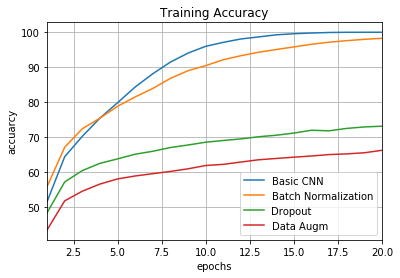

In [20]:
epochsn=np.arange(1,epochs+1)
plt.plot(epochsn,basic_tr_accuracy)
plt.plot(epochsn,bn_tr_accuracy)
plt.plot(epochsn,drop_tr_accuracy)
plt.plot(epochsn,aug_tr_accuracy)
plt.xlim((1,epochs))

plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuarcy')
plt.title('Training Accuracy')
plt.legend(['Baseline', 'BN', 'BN+Dropout', 'BN+Dropout+Aug'])

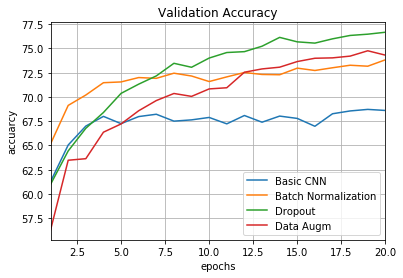

In [21]:
plt.plot(epochsn,basic_ts_accuracy)
plt.plot(epochsn,bn_ts_accuracy)
plt.plot(epochsn,drop_ts_accuracy)
plt.plot(epochsn,aug_ts_accuracy)
plt.xlim((1,epochs))
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuarcy')
plt.title('Validation Accuracy')
plt.legend(['Baseline', 'BN', 'BN+Dropout', 'BN+Dropout+Aug'])

Print out some images from the test class and display their predicted label.

In [22]:
# Load model
model = DropoutNet()
model.load_state_dict(torch.load("saved_drop_model.pt"));
model.eval()

# Load batch of test data
batch = next(iter(test_dl))
x_test, y_test = batch

# Use network to predict class
with torch.no_grad():
    yhat = model(x_test)

_, predicted = torch.max(yhat.data, 1)


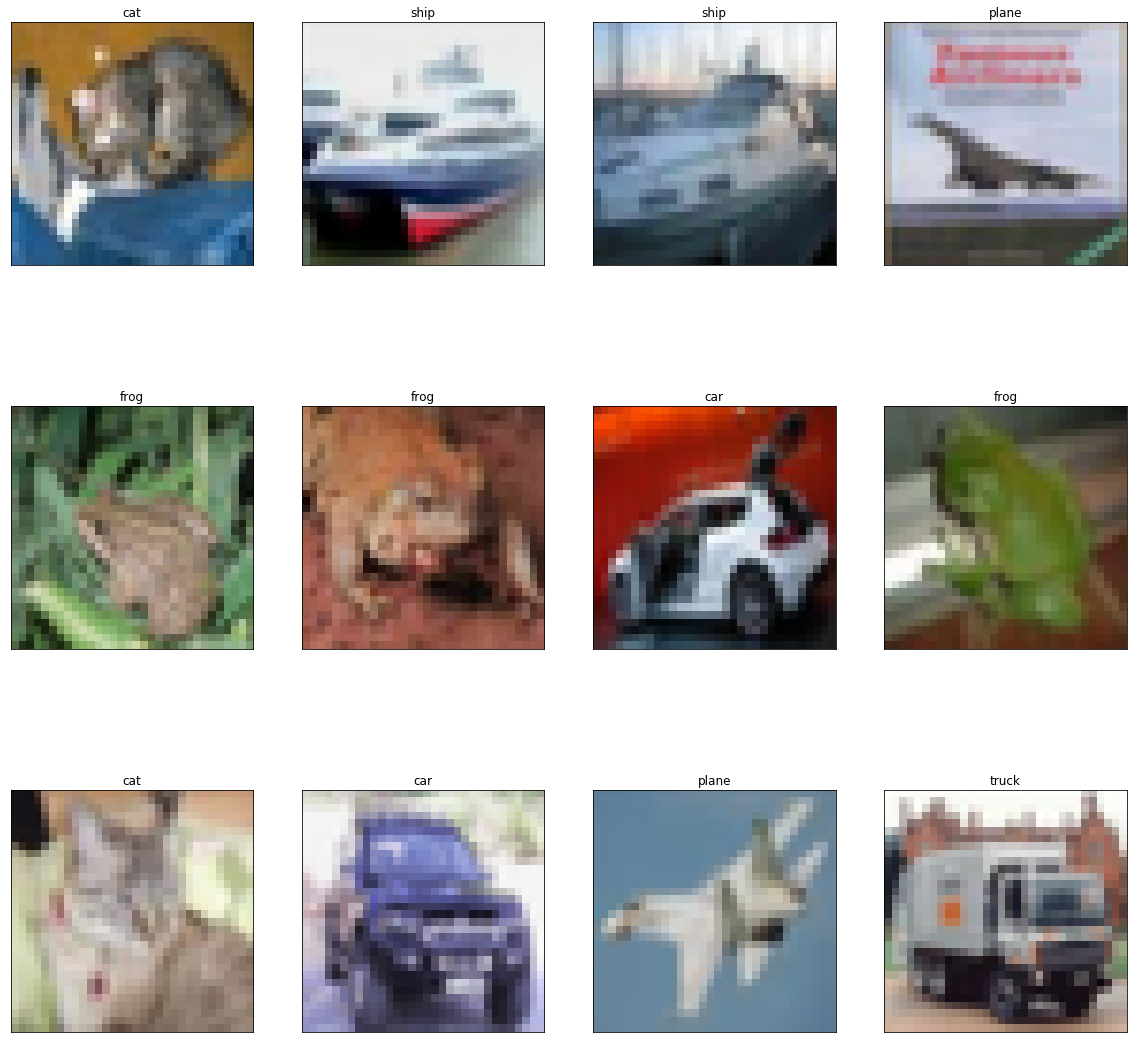

In [23]:
nplot = 12
nrow = 3
ncol = nplot/nrow
plt.figure(figsize=(20,20))
for i in range(nplot):
    plt.subplot(nrow,ncol,i+1)
    # unnormalize
    disp_img = x_test[i]/2 + 0.5
    imshow(disp_img,classes[predicted[i]])
    plt.xticks([])
    plt.yticks([])